In [1]:
from selenium import webdriver
import time
import numpy as np
import pandas as pd
import re
import math
from funcy import print_durations
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.support.ui import Select


In [2]:
class Liquor:
    '''
    Does most of the scraping. Detail to come...
    '''
    @print_durations()
    def __init__(self, products):
        beer_data = pd.DataFrame(columns=['product_name','availability_info','package_info',
                                          'reg_price(CAD)','sale_price(CAD)','savings(%)','sale_until',
                                          'star_rating','total_volume(ml)','cents_per_ml','cents_per_ml_per_ratings']) 

        for product_list in products:

            # product name
            product_name = product_list.find_element_by_tag_name('h3').text

            # packaging and volume info
            package_info = product_list.find_element_by_class_name("product-subtitle-info").text.split('\n')[0]

#             cnt_vol = re.findall(r'\d+',package_info)
            cnt_vol = re.findall(r'\w+', package_info)
    
            if len(cnt_vol) == 4: 
                cnt =  cnt_vol[0]
                vol =  cnt_vol[2]
                if cnt_vol[3]=='L':
                    vol = int(vol)*1000   # convert unit to ml
                
            else: 
                cnt, vol = 1, cnt_vol[0]
                if cnt_vol[1]=='L':
                    vol = int(vol)*1000   # convert unit to ml
                
          
            total_volume = math.prod([int(cnt),float(vol)])

            # price info
            sale_price = product_list.find_element_by_class_name("onsale-product-price").text
            reg_price = float(product_list.find_element_by_class_name("product-price").text.strip('$'))  # (small values are good)
            cents_per_ml = np.round(reg_price/total_volume,4)*100
            
#             print(product_name,sale_price)
            # availability_info
            availability_info = product_list.find_element_by_id("availability").text

            # sale end date info, also drop dollar sign
            if sale_price:
                sale_price = float(sale_price.strip('$'))
                sale_until = product_list.find_element_by_class_name("offer-date").text
                savings = np.round(((reg_price-sale_price)/reg_price),2)*100
            else:
                sale_price = np.nan
                sale_until = np.nan
                savings= np.nan

            # star ratings
            full_stars = product_list.find_elements_by_class_name("fa.fa-star") 
            half_stars = product_list.find_elements_by_class_name("fa.fa-star-o") 
            no_stars = product_list.find_elements_by_class_name("fa.fa-star-half-o") 

            if half_stars or full_stars:
                star_rating = len(full_stars) + .5*len(half_stars)
            else:
                star_rating = np.nan

            cents_per_ml_per_ratings = np.round(cents_per_ml/star_rating,4)  # (small values are good)


            df = pd.DataFrame({'product_name':[product_name],'availability_info':[availability_info],'package_info':[package_info],
                               'reg_price(CAD)':[reg_price],'sale_price(CAD)':[sale_price],'savings(%)':[savings],'sale_until':[sale_until],
                               'star_rating':[star_rating],'total_volume(ml)':total_volume, 'cents_per_ml':[cents_per_ml],'cents_per_ml_per_ratings':[cents_per_ml_per_ratings]})
            beer_data = pd.concat([beer_data, df], axis=0)
            beer_data.reset_index(drop=True, inplace=True)
        self.liquor_data = beer_data

In [3]:
# Driver setup
# ! pkill -f "(chrome)?(--headless)"

p_type,pkg_type = 'beer', 'can'

df = pd.DataFrame(columns=['product_name','availability_info','package_info',
                                          'reg_price(CAD)','sale_price(CAD)','savings(%)','sale_until',
                                          'star_rating','total_volume(ml)','cents_per_ml','cents_per_ml_per_ratings'])
   
for page in range(1,11):
    try:
        url = f'https://www.bcliquorstores.com/product-catalogue?search={p_type}%20{pkg_type}&sort=consumerRating:desc&page={page}'

        opts = Options()
        opts.add_argument("--incognito")
        opts.add_argument("--disable-popup-blocking")
        opts.headless =True
        driver = Chrome(options=opts)
        driver.get(url)
        driver.implicitly_wait(45)
        products = driver.find_elements_by_class_name("product-description-container")
        beer = Liquor(products)
        beer = beer.liquor_data
        df = pd.concat([df,beer], axis=0, ignore_index=True)
        driver.close()
    except IndexError:
        pass

 2076.30 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
 1086.44 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
 1086.29 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
 1086.05 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
 1086.01 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
 1086.57 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
 1086.18 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
 1086.18 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
  545.39 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)
    4.76 s in __init__(<__main__.Liquor objec..., [<selenium.webdriver.r...)


In [139]:
# first few data lines 
df.head()

,product_name,availability_info,package_info,reg_price(CAD),sale_price(CAD),savings(%),sale_until,star_rating,total_volume(ml),cents_per_ml,cents_per_ml_per_ratings
0,PHILLIPS BREWING - OCTOBOX 8 PACK TALL CAN,In Stock,8 x 473 ml,19.79,18.79,5.0,Oct 30,5.0,3784.0,0.52,0.104
1,DEAD FROG - WARHEAD BLACKBERRY IMPERIAL SOUR T...,In Stock,4 x 473 ml,14.29,NaN,NaN,NaN,5.0,1892.0,0.76,0.152
2,DAGERAAD - RAINSHINE TALL CAN,In Stock,4 x 473 ml,13.49,NaN,NaN,NaN,5.0,1892.0,0.71,0.142
3,RED RACER - DOZEN DONUTS MIXER CAN,In Stock,12 x 355 ml,22.99,NaN,NaN,NaN,5.0,4260.0,0.54,0.108
4,RED RACER - JUKE BOX VARIETY PACK TALL CAN,In Stock,8 x 500 ml,18.99,17.99,5.0,Oct 30,5.0,4000.0,0.47,0.094


In [42]:
# a corr plot
import plotly_corr_heatmap as pchm
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
def plotly_corr_heatmap(df):
    '''
    Takes a data frame
    Returns corr heatmaps using plotly 
    '''
    corr = df.corr().round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    df_mask = corr.mask(mask)
    fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                    x=df_mask.columns.tolist(),
                                    y=df_mask.columns.tolist(),
                                    colorscale=px.colors.diverging.RdBu,
                                    showscale=True, ygap=1, xgap=1
                                    )
    fig.update_layout(
        font_size=16,
        title ='Correlations',
        margin = dict(l=0,r=0,b=0,t=60),
        coloraxis_colorbar_x=.7,
        width=800, 
        height=600,
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        xaxis_zeroline=False,
        yaxis_zeroline=False,
        yaxis_autorange='reversed',
        paper_bgcolor = 'rgba(0,0,0,0)', #'aliceblue',
        plot_bgcolor='rgba(0,0,0,0)'
        )
    for i in range(len(fig.layout.annotations)):
        if fig.layout.annotations[i].text == 'nan':
            fig.layout.annotations[i].text = ""

    fig.update_xaxes(side="bottom")

    return fig

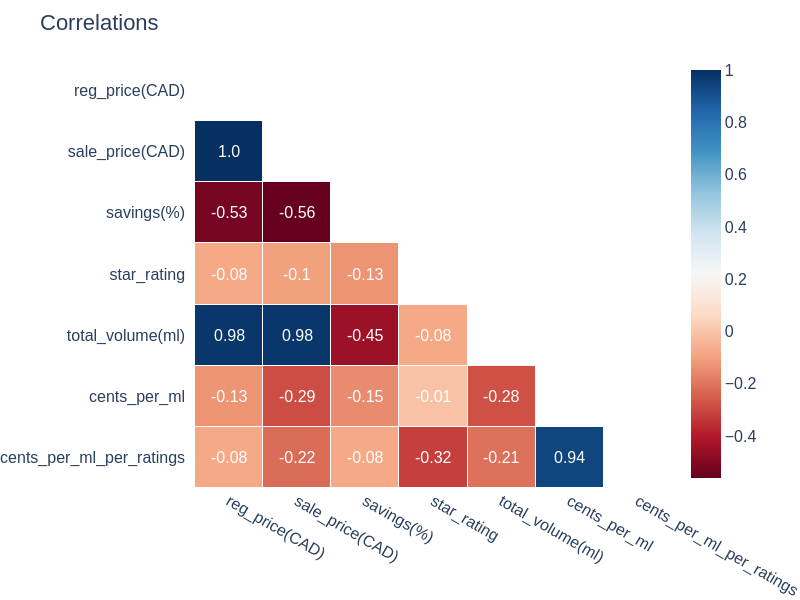

In [136]:
fg = pchm.plotly_corr_heatmap(df)
fg.show(renderer='png')  # github does not like plotly (js)

- people don't seem to care about price when rating beer
- It appears people rate beers generously. The minimum is 3.5 stars. Maybe they do it when tipsy and in a good mood
- Other more likely predictors of good ratings are may be alcohol contents, which I did not scrap. Also, did not scrap number of ratings. <br>A five star from 1 consumer should not carry the same weight as a five star from 100 happy consumers.
- When on sale, savings as a percentage of regular price are slightly higher for lower total volume of beer.
- Keep in mind product ratings are not correlated with price or volume of beer. But the following information could be useful when choosing beer 

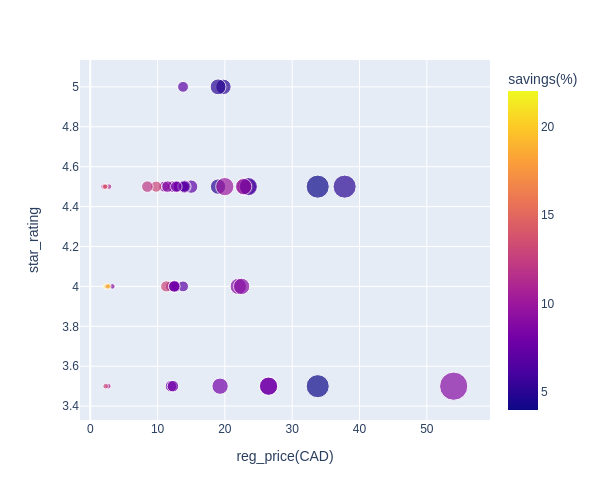

In [137]:
fg = px.scatter(df.dropna(), x='reg_price(CAD)',y='star_rating',size='total_volume(ml)',color='savings(%)')
fg.update_layout(width=600)
fg.show(renderer='png')  # github does not like plotly (js)

<h3> The top five best value for money beers are </h3>
    
<!--     metric: $$\frac{cents\_per\_ml}{star\_rating}$$ -->
    
 
   

In [128]:
df.nsmallest(5, "cents_per_ml_per_ratings", keep='all')

,product_name,availability_info,package_info,reg_price(CAD),sale_price(CAD),savings(%),sale_until,star_rating,total_volume(ml),cents_per_ml,cents_per_ml_per_ratings
165,PACIFIC WESTERN - CARIBOO MALT CAN,In Stock,6 x 355 ml,7.79,NaN,NaN,NaN,4.5,2130.0,0.37,0.0822
164,CARLING - EXTRA OLD STOCK CAN,In Stock,15 x 355 ml,20.49,NaN,NaN,NaN,4.5,5325.0,0.38,0.0844
172,LABATT - KOOTENAY TRUE ALE CAN,In Stock,6 x 355 ml,7.99,NaN,NaN,NaN,4.5,2130.0,0.38,0.0844
176,SHAFTEBURY - 15 PACK CAN,In Stock,15 x 355 ml,19.99,17.99,10.0,Oct 30,4.5,5325.0,0.38,0.0844
186,LABATT - LUCKY LAGER 36 CAN,In Stock,36 x 355 ml,48.99,NaN,NaN,NaN,4.5,12780.0,0.38,0.0844


<h3> The top five cheapest beers are </h3>
    
- there may be ties. Hence more than five beer types could fall under this category

In [134]:
df.nsmallest(5, "cents_per_ml", keep='all')

,product_name,availability_info,package_info,reg_price(CAD),sale_price(CAD),savings(%),sale_until,star_rating,total_volume(ml),cents_per_ml,cents_per_ml_per_ratings
206,BALDERDASH BREWING - SNEAKY WEASEL CRAFT LAGER...,In Stock,8 x 355 ml,9.99,NaN,NaN,NaN,3.5,2840.0,0.35,0.1000
223,PACIFIC WESTERN - CARIBOO GENUINE 24 PACK CAN,In Stock,24 x 355 ml,30.99,NaN,NaN,NaN,3.5,8520.0,0.36,0.1029
165,PACIFIC WESTERN - CARIBOO MALT CAN,In Stock,6 x 355 ml,7.79,NaN,NaN,NaN,4.5,2130.0,0.37,0.0822
63,GREAT WESTERN BREWING - OLYMPIA CAN,In Stock,15 x 355 ml,20.49,NaN,NaN,NaN,4.0,5325.0,0.38,0.0950
164,CARLING - EXTRA OLD STOCK CAN,In Stock,15 x 355 ml,20.49,NaN,NaN,NaN,4.5,5325.0,0.38,0.0844
172,LABATT - KOOTENAY TRUE ALE CAN,In Stock,6 x 355 ml,7.99,NaN,NaN,NaN,4.5,2130.0,0.38,0.0844
176,SHAFTEBURY - 15 PACK CAN,In Stock,15 x 355 ml,19.99,17.99,10.0,Oct 30,4.5,5325.0,0.38,0.0844
186,LABATT - LUCKY LAGER 36 CAN,In Stock,36 x 355 ml,48.99,NaN,NaN,NaN,4.5,12780.0,0.38,0.0844
235,STROH CANADA - COLT 45 MALT LIQUOR CAN,In Stock,6 x 355 ml,7.99,NaN,NaN,NaN,3.5,2130.0,0.38,0.1086


<h3>The least five best value for money beers:

In [127]:
df.nlargest(5, "cents_per_ml_per_ratings", keep='all')

,product_name,availability_info,package_info,reg_price(CAD),sale_price(CAD),savings(%),sale_until,star_rating,total_volume(ml),cents_per_ml,cents_per_ml_per_ratings
230,ROOT BEER - DR. MCGILLICUDDY'S,In Stock,750 ml,18.99,NaN,NaN,NaN,3.5,750.0,2.53,0.7229
225,FIELD HOUSE BREWING - DARK SOUR TALL CAN,In Stock,4 x 473 ml,16.49,NaN,NaN,NaN,3.5,1892.0,0.87,0.2486
222,BOMBER BREWING - BOMBER OKTOBERFEST TALL CAN,In Stock,4 x 473 ml,14.49,NaN,NaN,NaN,3.5,1892.0,0.77,0.2200
194,TIN WHISTLE - KILLER BEE DARK HONEY ALE,In Stock,650 ml,5.99,NaN,NaN,NaN,4.5,650.0,0.92,0.2044
228,FOAMERS' FOLLY BREWING CORP. - BEETLEJUICE SOU...,In Stock,4 x 473 ml,13.29,NaN,NaN,NaN,3.5,1892.0,0.70,0.2000


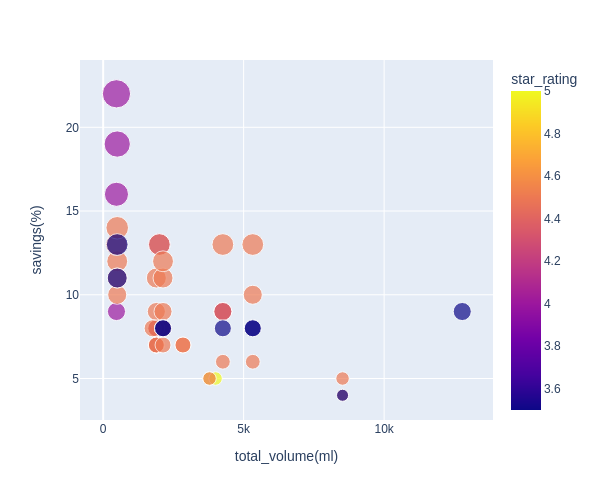

In [138]:
fg = px.scatter(df.dropna(), color='star_rating',x='total_volume(ml)',y='savings(%)', size='savings(%)')
fg.update_layout(width=600)
fg.show(renderer='png')  # github does not like plotly (js)

<h3>Conclusion </h3>
We just completed the most fun and simple data science project. We scraped beer data (N = 240) from a website, and analysed it. The more ambitious goal of this exercise was to build a beer classifier model. It turns out beer ratings are not correlated with any of the features in our dataset. Maybe other factors such as alcohol content, and culture are better predictors of good beer. Until, if ever, come back to this project with more data, we can enjoy the basic metric we came up with to help us choose beer whenever we hit the liquor store!

In [ ]:
# save data to  compressed csv file
compression_opts = dict(method='zip',
                        archive_name='beer_data.csv')  
df.to_csv('beer_data.zip', index=False,
          compression=compression_opts) 


In [140]:
# %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
